#单位区和功能区分类

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
from torchvision.models import ResNet50_Weights
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

In [2]:
# 设置超参数
num_epochs = 10
batch_size = 32
learning_rate = 0.001

# 数据增强和预处理
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
# 数据加载
data_dir = '../../images_dataset_resnet_train/1'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size,
                             shuffle=True, num_workers=4)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 打印所使用的设备
print(f'Using device: {device}')

Using device: cuda:0


In [4]:
# 没有冻结的情形
# 定义模型
weights = ResNet50_Weights.IMAGENET1K_V1  
model_ft = models.resnet50(weights=weights)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=learning_rate, momentum=0.9)

# 训练模型
def train_model(model, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # 每个epoch都有训练和验证阶段
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 训练模式
            else:
                model.eval()   # 验证模式

            running_loss = 0.0
            running_corrects = 0

            # 迭代数据
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 梯度清零
                optimizer.zero_grad()

                # 前向传播
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 只有在训练阶段才进行反向传播和优化
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 统计
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

    return model


In [5]:
# 训练和验证模型
model_ft = train_model(model_ft, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/10
----------


In [4]:
# 冻结所有的特征提取层，只训练最后的分类层
# 定义模型
weights = ResNet50_Weights.IMAGENET1K_V1  
model_ft = models.resnet50(weights=weights)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

# 冻结所有的特征提取层
for param in model_ft.parameters():
    param.requires_grad = False

# 只训练最后的分类层
for param in model_ft.fc.parameters():
    param.requires_grad = True

model_ft = model_ft.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.fc.parameters(), lr=learning_rate, momentum=0.9)

# 训练模型
def train_model(model, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # 每个epoch都有训练和验证阶段
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 训练模式
            else:
                model.eval()   # 验证模式

            running_loss = 0.0
            running_corrects = 0

            # 迭代数据
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 梯度清零
                optimizer.zero_grad()

                # 前向传播
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 只有在训练阶段才进行反向传播和优化
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 统计
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

    return model

In [5]:
# 训练和验证模型
model_ft = train_model(model_ft, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/50
----------
train Loss: 2.7208 Acc: 0.3520
val Loss: 2.3910 Acc: 0.4250
Epoch 2/50
----------
train Loss: 1.9171 Acc: 0.6371
val Loss: 2.1671 Acc: 0.4000
Epoch 3/50
----------
train Loss: 1.5162 Acc: 0.6965
val Loss: 2.0287 Acc: 0.3750
Epoch 4/50
----------
train Loss: 1.2887 Acc: 0.7316
val Loss: 1.9740 Acc: 0.4250
Epoch 5/50
----------
train Loss: 1.1479 Acc: 0.7561
val Loss: 1.9482 Acc: 0.4500
Epoch 6/50
----------
train Loss: 1.0521 Acc: 0.7690
val Loss: 1.9190 Acc: 0.4500
Epoch 7/50
----------
train Loss: 0.9710 Acc: 0.7860
val Loss: 1.9083 Acc: 0.4250
Epoch 8/50
----------
train Loss: 0.9152 Acc: 0.7965
val Loss: 1.8948 Acc: 0.4500
Epoch 9/50
----------
train Loss: 0.8630 Acc: 0.8077
val Loss: 1.9073 Acc: 0.4250
Epoch 10/50
----------
train Loss: 0.8173 Acc: 0.8143
val Loss: 1.8821 Acc: 0.4500
Epoch 11/50
----------
train Loss: 0.7796 Acc: 0.8210
val Loss: 1.8897 Acc: 0.4500
Epoch 12/50
----------
train Loss: 0.7502 Acc: 0.8269
val Loss: 1.8720 Acc: 0.5000
Epoch 13/50
-

In [6]:
# 冻结所有的特征提取层，解冻最后两个残差块
# 定义模型
weights = models.ResNet50_Weights.IMAGENET1K_V1  
model_ft = models.resnet50(weights=weights)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, len(class_names))
)

# 冻结所有的特征提取层
for param in model_ft.parameters():
    param.requires_grad = False

# 解冻最后两个block和分类器层
for name, param in model_ft.named_parameters():
    if "layer4" in name or "layer3" in name or "fc" in name:
        param.requires_grad = True

model_ft = model_ft.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=1e-4)

# 定义学习率调度器
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# 训练模型
def train_model(model, criterion, optimizer, scheduler, num_epochs=50):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # 每个epoch都有训练和验证阶段
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 训练模式
            else:
                model.eval()   # 验证模式

            running_loss = 0.0
            running_corrects = 0

            # 迭代数据
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 梯度清零
                optimizer.zero_grad()

                # 前向传播
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 只有在训练阶段才进行反向传播和优化
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 统计
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 记录损失和准确率
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.cpu().numpy())  # 移动到CPU
                scheduler.step()
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.cpu().numpy())  # 移动到CPU

    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

# 训练和验证模型
model_ft, train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_model(
    model_ft, criterion, optimizer, scheduler, num_epochs=num_epochs
)


Epoch 1/10
----------
train Loss: 1.1826 Acc: 0.6674
val Loss: 1.7715 Acc: 0.5750
Epoch 2/10
----------
train Loss: 0.2670 Acc: 0.9251
val Loss: 2.0810 Acc: 0.5500
Epoch 3/10
----------
train Loss: 0.1925 Acc: 0.9461
val Loss: 1.8086 Acc: 0.6500
Epoch 4/10
----------
train Loss: 0.1517 Acc: 0.9584
val Loss: 2.3851 Acc: 0.6250
Epoch 5/10
----------
train Loss: 0.1172 Acc: 0.9677
val Loss: 1.8691 Acc: 0.5750
Epoch 6/10
----------
train Loss: 0.1158 Acc: 0.9667
val Loss: 2.3878 Acc: 0.6500
Epoch 7/10
----------
train Loss: 0.0976 Acc: 0.9730
val Loss: 2.4415 Acc: 0.6250
Epoch 8/10
----------
train Loss: 0.0618 Acc: 0.9830
val Loss: 2.6155 Acc: 0.6750
Epoch 9/10
----------
train Loss: 0.0322 Acc: 0.9908
val Loss: 2.6027 Acc: 0.6500
Epoch 10/10
----------
train Loss: 0.0312 Acc: 0.9914
val Loss: 2.6230 Acc: 0.6500


In [7]:
# 冻结所有的特征提取层，解冻最后一个残差块
# 定义模型
weights = models.ResNet50_Weights.IMAGENET1K_V1  
model_ft = models.resnet50(weights=weights)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, len(class_names))
)

# 冻结所有的特征提取层
for param in model_ft.parameters():
    param.requires_grad = False

# 解冻最后两个block和分类器层
for name, param in model_ft.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True

model_ft = model_ft.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=1e-4)

# 定义学习率调度器
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# 训练模型
def train_model(model, criterion, optimizer, scheduler, num_epochs=50):
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # 每个epoch都有训练和验证阶段
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 训练模式
            else:
                model.eval()   # 验证模式

            running_loss = 0.0
            running_corrects = 0

            # 迭代数据
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 梯度清零
                optimizer.zero_grad()

                # 前向传播
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 只有在训练阶段才进行反向传播和优化
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 统计
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 记录损失和准确率
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.cpu().numpy())  # 移动到CPU
                scheduler.step()
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.cpu().numpy())  # 移动到CPU

    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

# 训练和验证模型
model_ft, train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_model(
    model_ft, criterion, optimizer, scheduler, num_epochs=num_epochs
)


Epoch 1/10
----------
train Loss: 1.2867 Acc: 0.6367
val Loss: 1.9229 Acc: 0.5000
Epoch 2/10
----------
train Loss: 0.3056 Acc: 0.9127
val Loss: 2.4663 Acc: 0.5250
Epoch 3/10
----------
train Loss: 0.2031 Acc: 0.9417
val Loss: 2.0583 Acc: 0.6250
Epoch 4/10
----------
train Loss: 0.1559 Acc: 0.9570
val Loss: 2.3232 Acc: 0.5250
Epoch 5/10
----------
train Loss: 0.1324 Acc: 0.9612
val Loss: 2.0479 Acc: 0.6250
Epoch 6/10
----------
train Loss: 0.1183 Acc: 0.9680
val Loss: 2.0192 Acc: 0.6000
Epoch 7/10
----------
train Loss: 0.0955 Acc: 0.9727
val Loss: 1.8421 Acc: 0.7000
Epoch 8/10
----------
train Loss: 0.0676 Acc: 0.9814
val Loss: 2.1433 Acc: 0.6250
Epoch 9/10
----------
train Loss: 0.0456 Acc: 0.9871
val Loss: 2.2923 Acc: 0.6000
Epoch 10/10
----------
train Loss: 0.0488 Acc: 0.9863
val Loss: 2.1306 Acc: 0.6500


In [7]:
# 保存模型
torch.save(model_ft.state_dict(), 'resnet50_unit.pth')

In [8]:
# 加载保存的模型
model_ft = models.resnet50(weights=None)  # 初始化模型
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))  # 替换最后一层
model_ft.load_state_dict(torch.load('resnet50_unit.pth'))  # 加载训练好的权重
model_ft = model_ft.to(device)
model_ft.eval()  # 设置模型为评估模式

# 定义图片预处理步骤
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

The predicted class for the image is: 0-北京公联


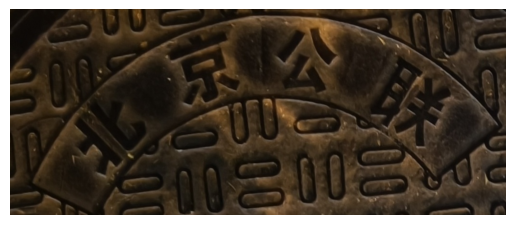

In [9]:
# 导入图片并预处理
img_path = '../../resnet_class_backup/origin/0/0-北京公联/0-北京公联_IMG_20240629_003830_target_0.jpg'

input_image = Image.open(img_path)
input_tensor = preprocess(input_image)
input_tensor = input_tensor.unsqueeze(0)  # 增加一个batch维度
input_tensor = input_tensor.to(device)

# 进行推理
with torch.no_grad():
    output = model_ft(input_tensor)
    _, preds = torch.max(output, 1)
    predicted_class = class_names[preds[0]]

print(f'The predicted class for the image is: {predicted_class}')

# 显示原始图片
plt.imshow(input_image)
plt.axis('off')  # 不显示坐标轴
plt.show()

/home/u2021213565/.conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/u2021213565/.conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/u2021213565/.conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

              precision    recall  f1-score   support

 0-中关村信息工程公司       0.00      0.00      0.00         1
      0-北京供电       0.00      0.00      0.00         1
     0-北京供电局       0.00      0.00      0.00         1
      0-北京公联       0.00      0.00      0.00         1
0-北京市公安交通管理局       1.00      1.00      1.00         1
  0-北京市市政工程局       1.00      1.00      1.00         1
      0-北京市政       0.50      0.67      0.57         3
    0-北京市政工程       0.00      0.00      0.00         1
   0-北京市热力公司       0.00      0.00      0.00         1
   0-北京市电信公司       0.00      0.00      0.00         1
  0-北京市自来水公司       1.00      1.00      1.00         1
  0-北京市自来水集团       0.60      1.00      0.75         3
  0-北京市路灯管理处       0.00      0.00      0.00         1
    0-北京排水集团       0.00      0.00      0.00         1
      0-北京电信       0.00      0.00      0.00         1
      0-北京电力       0.00      0.00      0.00         1
      0-北京路灯       1.00      1.00      1.00         3
      0-北京通信       0.50    

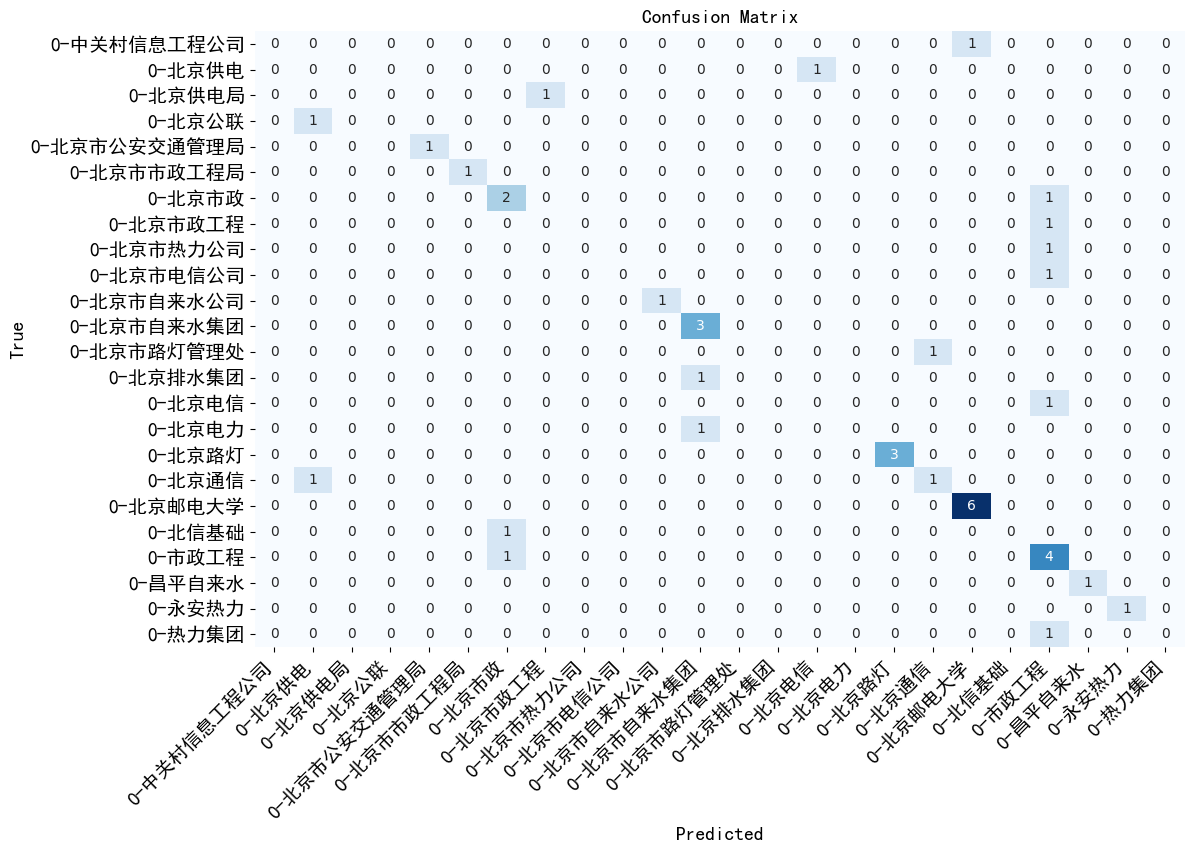

In [14]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties
font = FontProperties(fname="./SimHei.ttf", size=14)

# 设置设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 定义数据预处理步骤
data_transforms = {
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 加载测试集
data_dir = '../../images_dataset_resnet_train/0/val'
image_datasets = datasets.ImageFolder(data_dir, data_transforms['test'])
dataloaders = DataLoader(image_datasets, batch_size=32, shuffle=False, num_workers=4)
class_names = image_datasets.classes

# 加载模型
model_ft = models.resnet50(weights=None)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft.load_state_dict(torch.load('resnet50_unit.pth'))
model_ft = model_ft.to(device)
model_ft.eval()

# 定义测试函数
def evaluate_model(model, dataloader):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

# 评估模型
true_labels, pred_labels = evaluate_model(model_ft, dataloaders)

# 打印分类报告
print(classification_report(true_labels, pred_labels, target_names=class_names))

# 绘制混淆矩阵
# conf_mat = confusion_matrix(true_labels, pred_labels)
# plt.figure(figsize=(12, 8))
# sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
# heatmap.set_xticklabels(class_names, fontproperties=font)
# heatmap.set_yticklabels(class_names, fontproperties=font)
# plt.xlabel('Predicted',fontproperties=font)
# plt.ylabel('True',fontproperties=font)
# plt.title('Confusion Matrix')
# plt.show()

# 计算混淆矩阵
conf_mat = confusion_matrix(true_labels, pred_labels)

# 创建热力图
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues", cbar=False)

# 设置刻度标签的字体
heatmap.set_xticklabels(class_names, fontproperties=font, rotation=45, ha="right")
heatmap.set_yticklabels(class_names, fontproperties=font, rotation=0)

# 设置坐标轴标签和标题
plt.xlabel('Predicted', fontproperties=font)
plt.ylabel('True', fontproperties=font)
plt.title('Confusion Matrix', fontproperties=font)

# 显示图形
plt.show()


/home/u2021213565/.conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/u2021213565/.conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/u2021213565/.conda/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

              precision    recall  f1-score   support

 0-中关村信息工程公司       0.53      0.82      0.64       384
      0-北京供电       0.00      0.00      0.00       384
     0-北京供电局       1.00      0.07      0.14       384
      0-北京公联       0.00      0.00      0.00       384
0-北京市公安交通管理局       0.85      1.00      0.92       384
  0-北京市市政工程局       0.50      1.00      0.67       384
      0-北京市政       0.39      0.76      0.52       500
    0-北京市政工程       0.43      0.24      0.31       384
   0-北京市热力公司       0.13      0.02      0.03       384
   0-北京市电信公司       0.00      0.00      0.00       384
  0-北京市自来水公司       0.76      0.98      0.85       384
  0-北京市自来水集团       0.41      0.87      0.55       500
  0-北京市路灯管理处       0.01      0.00      0.00       384
    0-北京排水集团       0.02      0.01      0.01       384
      0-北京电信       0.17      0.41      0.24       384
      0-北京电力       0.00      0.00      0.00       384
      0-北京路灯       0.91      1.00      0.95       500
      0-北京通信       0.19    

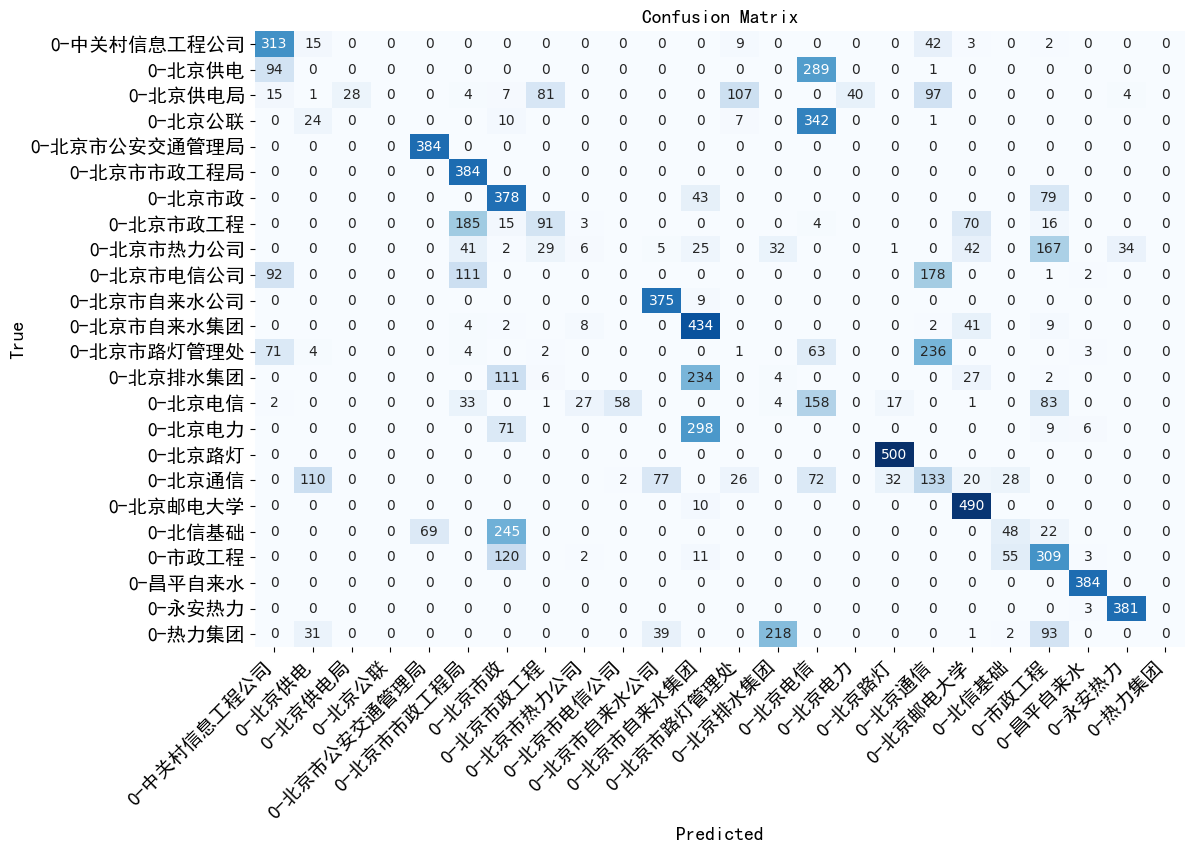

In [6]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties
font = FontProperties(fname="./SimHei.ttf", size=14)

# 设置设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 定义数据预处理步骤
data_transforms = {
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 加载测试集
data_dir = '../../images_dataset_resnet_train/0/val0'
image_datasets = datasets.ImageFolder(data_dir, data_transforms['test'])
dataloaders = DataLoader(image_datasets, batch_size=32, shuffle=False, num_workers=4)
class_names = image_datasets.classes

# 加载模型
model_ft = models.resnet50(weights=None)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft.load_state_dict(torch.load('resnet50_unit.pth'))
model_ft = model_ft.to(device)
model_ft.eval()

# 定义测试函数
def evaluate_model(model, dataloader):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

# 评估模型
true_labels, pred_labels = evaluate_model(model_ft, dataloaders)

# 打印分类报告
print(classification_report(true_labels, pred_labels, target_names=class_names))

# 绘制混淆矩阵
# conf_mat = confusion_matrix(true_labels, pred_labels)
# plt.figure(figsize=(12, 8))
# sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
# heatmap.set_xticklabels(class_names, fontproperties=font)
# heatmap.set_yticklabels(class_names, fontproperties=font)
# plt.xlabel('Predicted',fontproperties=font)
# plt.ylabel('True',fontproperties=font)
# plt.title('Confusion Matrix')
# plt.show()

# 计算混淆矩阵
conf_mat = confusion_matrix(true_labels, pred_labels)

# 创建热力图
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues", cbar=False)

# 设置刻度标签的字体
heatmap.set_xticklabels(class_names, fontproperties=font, rotation=45, ha="right")
heatmap.set_yticklabels(class_names, fontproperties=font, rotation=0)

# 设置坐标轴标签和标题
plt.xlabel('Predicted', fontproperties=font)
plt.ylabel('True', fontproperties=font)
plt.title('Confusion Matrix', fontproperties=font)

# 显示图形
plt.show()
